# Import

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator


import math

# Phosphene Density Maps

In [4]:
from phosphene.density import VisualFieldMapper
from phosphene.uniformity import DynamicAmplitudeNormalizer

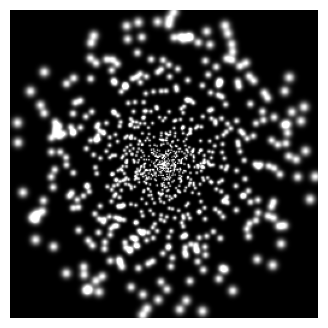

Loss = 0.0027: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 153.77iter/s]


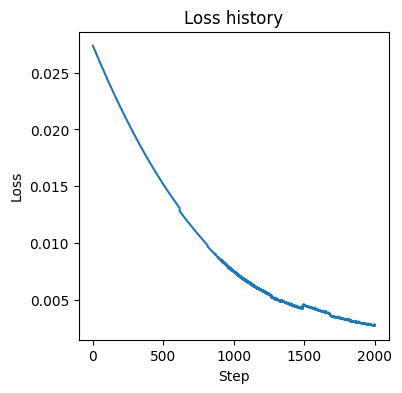

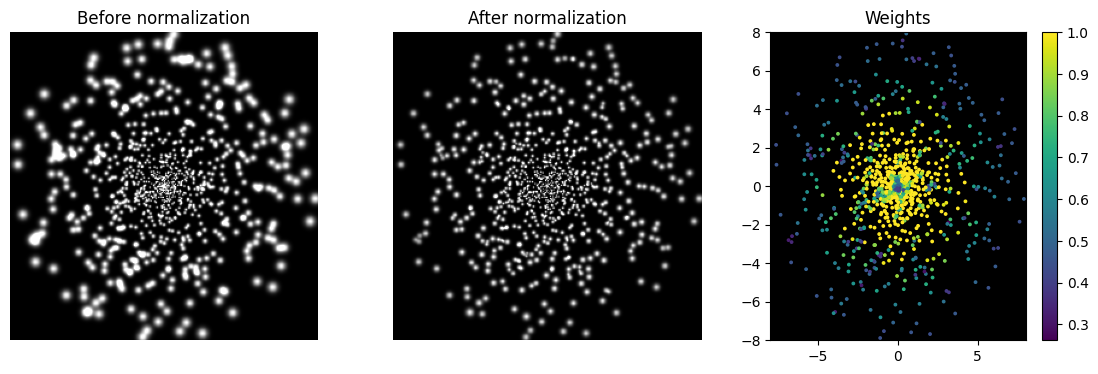

Percentage of amplitude: 76.55%


In [5]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')
# batch_size = 4
params['run']['batch_size'] = 2

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = (amplitude * torch.ones(n_phosphenes).cuda().detach()).unsqueeze(0).repeat(params['run']['batch_size'], 1) # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)


# Show the phosphene image
plt.figure(figsize=(4, 4))
plt.imshow(phosphenes.cpu()[0], cmap='gray')
plt.axis('off')
plt.show()

stim_init = (amplitude * torch.ones(simulator.num_phosphenes, device='cuda')).unsqueeze(0).repeat(params['run']['batch_size'], 1)

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before[0].cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after[0].cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights[0].cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights[0].sum() / simulator.num_phosphenes*100:.2f}%')

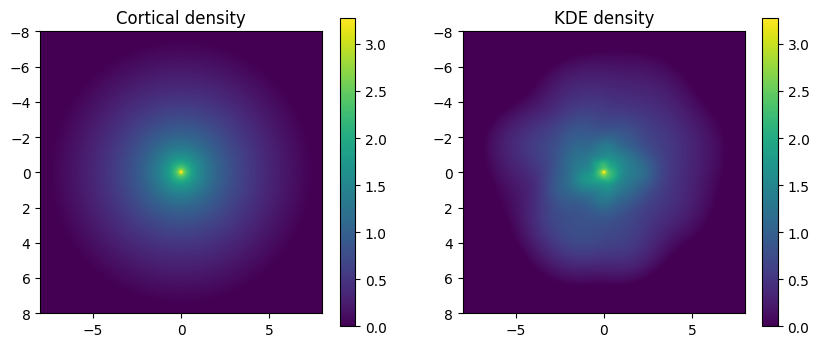

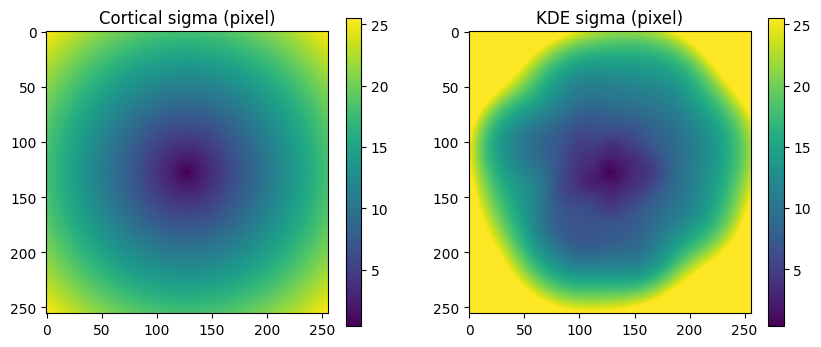

In [6]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=16, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Image processing for Phosphene Vision

In [7]:
from data.local_datasets import LaPaDataset
from spatial_frequency.components.modulated_conv2d import UnifiedInputModulation
import yaml

def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked


cfg = load_config('../config/256x256_LaPa.yaml')
LaPa_dataset = LaPaDataset(cfg)

In [8]:
def robust_percentile_normalization(electrode, amplitude, threshold, low_perc=5, high_perc=95, gamma=1.0):
    """
    Normalize the stimulation vector in a robust, contrast-preserving way.

    This function performs the following steps:
      1. Subtracts a given threshold (values below threshold become 0).
      2. Computes low and high percentiles (e.g., 5th and 95th) of the resulting values.
      3. Linearly scales values between these percentiles to [0, 1], then applies an optional gamma correction.
      4. Scales the result to the desired amplitude.

    Args:
        electrode (torch.Tensor): Input stimulation values.
        amplitude (float): Desired maximum amplitude.
        threshold (float): Activation threshold (e.g. your activation_threshold).
        low_perc (float): Lower percentile (default 5).
        high_perc (float): Upper percentile (default 95).
        gamma (float): Gamma exponent for power-law scaling (default 1.0 means linear scaling).
        
    Returns:
        torch.Tensor: Normalized stimulation values, with zeros preserved.
    """
    # Subtract threshold and clamp to 0 so that values below threshold remain 0.
    above_thresh = electrode - threshold
    above_thresh = torch.clamp(above_thresh, min=0.0)
    
    # Compute robust lower and upper bounds using percentiles.
    # Use torch.quantile (available in PyTorch 1.7+; adjust if needed).
    low_val = torch.quantile(above_thresh, low_perc / 100.0)
    high_val = torch.quantile(above_thresh, high_perc / 100.0)
    
    # Avoid division by zero if high_val == low_val.
    range_val = high_val - low_val + 1e-8

    # Linearly map values in the range [low_val, high_val] to [0, 1]
    normalized = (above_thresh - low_val) / range_val
    normalized = torch.clamp(normalized, 0.0, 1.0)

    # Apply gamma correction to adjust contrast if needed.
    normalized = normalized ** gamma

    # Scale to the desired amplitude.
    normalized = normalized * amplitude

    return normalized


# Dilation is used for the reg-loss on the phosphene image: phosphenes do not have to map 1 on 1, small offset is allowed.
def dilation5x5(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[[0., 0., 1., 0., 0.],
                              [0., 1., 1., 1., 0.],
                              [1., 1., 1., 1., 1.],
                              [0., 1., 1., 1., 0.],
                              [0., 0., 1., 0., 0.]]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

def dilation3x3(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[
                              [ 0, 1., 0.],
                              [ 1., 1., 1.],
                              [ 0., 1., 0.],]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

In [9]:
sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="log",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer_gauss = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="gaussian",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer_gauss.eval()

UnifiedInputModulation()

In [10]:
def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

In [11]:
image_processing_dict = {}

threshold = params['thresholding']['rheobase']

for image_index, batch in enumerate(LaPa_dataset):
    image = batch['image'].unsqueeze(0)
    contour = batch['contour'].unsqueeze(0)

    # dilate the contour 5x5
    contour = dilation5x5(contour)
    # contour = modified_cdf_normalization(contour, 1)

    LoG = layer(image).clip(0, None)
    LoG = (LoG - LoG.min()) / (LoG.max() - LoG.min())
    LoG = LoG.max(1, keepdim=True).values

    grayscale = image.mean(dim=1, keepdim=True)
    grayscale_gauss = layer_gauss(grayscale).clip(0, None)

    canny_edge = cv2.Canny((image*255).squeeze(0).permute(1,2,0).cpu().numpy().astype(np.uint8), 100, 200)
    canny_edge = torch.tensor(canny_edge).float().cuda().detach()
    canny_edge = canny_edge / canny_edge.max()
    canny_edge = canny_edge.unsqueeze(0).unsqueeze(0)

    random_image = rand_perlin_2d((256, 256), (4, 4)).unsqueeze(0).unsqueeze(0).cuda().detach()
    random_image = (random_image - random_image.min()) / (random_image.max() - random_image.min())

    # 1) Grayscale
    simulator.reset()
    grayscale_electrode = simulator.sample_stimulus(grayscale, rescale=True)
    grayscale_electrode = robust_percentile_normalization(grayscale_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    grayscale_electrode = grayscale_electrode * stim_weights
    grayscale_phosphenes = simulator(grayscale_electrode).unsqueeze(0).unsqueeze(0)

    # 1.5) Gaussian
    simulator.reset()
    grayscale_gauss_electrode = simulator.sample_stimulus(grayscale_gauss, rescale=True)
    grayscale_gauss_electrode = robust_percentile_normalization(grayscale_gauss_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    grayscale_gauss_electrode = grayscale_gauss_electrode * stim_weights
    grayscale_gauss_phosphenes = simulator(grayscale_gauss_electrode).unsqueeze(0).unsqueeze(0)

    # 2) Contour
    simulator.reset()
    contour_electrode = simulator.sample_stimulus(contour, rescale=True)
    contour_electrode = robust_percentile_normalization(contour_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    contour_electrode = contour_electrode * stim_weights
    contour_phosphenes = simulator(contour_electrode).unsqueeze(0).unsqueeze(0)

    # 2.5) Canny edge
    simulator.reset()
    canny_edge_electrode = simulator.sample_stimulus(canny_edge, rescale=True)
    canny_edge_electrode = robust_percentile_normalization(canny_edge_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    canny_edge_electrode = canny_edge_electrode * stim_weights
    canny_edge_phosphenes = simulator(canny_edge_electrode).unsqueeze(0).unsqueeze(0)

    # 3) LoG response
    simulator.reset()
    LoG_electrode = simulator.sample_stimulus(LoG, rescale=True)
    LoG_electrode = robust_percentile_normalization(LoG_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    LoG_electrode = LoG_electrode * stim_weights
    LoG_phosphenes = simulator(LoG_electrode).unsqueeze(0).unsqueeze(0)

    # Sanity check: randomize the stimulation vector
    simulator.reset()
    random_electrode = simulator.sample_stimulus(random_image, rescale=True)
    random_electrode = robust_percentile_normalization(random_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    random_electrode = random_electrode * stim_weights
    random_phosphenes = simulator(random_electrode).unsqueeze(0).unsqueeze(0)
    

    image_processing_dict[image_index] = {
    'image': image,
    'grayscale': {
        'stim': grayscale,
        'phosphenes': grayscale_phosphenes
    },
    'grayscale_gauss': {
        'stim': grayscale_gauss,
        'phosphenes': grayscale_gauss_phosphenes
    },
    'contour': {
        'stim': contour,
        'phosphenes': contour_phosphenes
    },
    'canny_edge': {
        'stim': canny_edge,
        'phosphenes': canny_edge_phosphenes
    },
    'LoG': {
        'stim': LoG,
        'phosphenes': LoG_phosphenes
    },
    'random': {
        'stim': random_image,
        'phosphenes': random_phosphenes
    } 
    }
    
    if image_index == 25:
        break

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
torch.use_deterministic_algorithms(False)

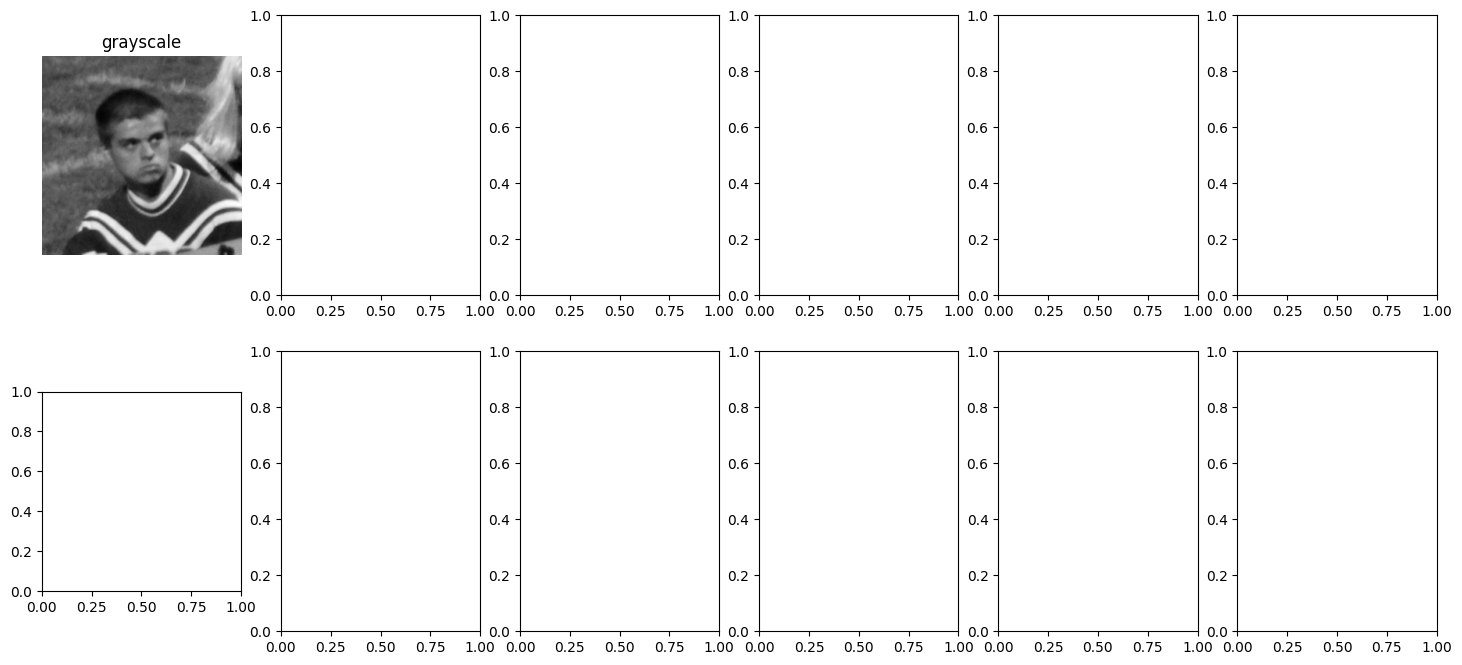

interactive(children=(IntSlider(value=12, description='image_index', max=25), Output()), _dom_classes=('widget…

<function __main__.show_image_processing(image_index)>

In [13]:
# show all stimuli and phosphenes
def show_image_processing(image_index):
    fig, axs = plt.subplots(2, 6, figsize=(18, 8))
    axs = axs.ravel()

    dict_without_image = {k: v for k, v in image_processing_dict[image_index].items() if k != 'image'}

    for i, (key, value) in enumerate(dict_without_image.items()):
        stim = value['stim']
        phosphenes = value['phosphenes']

        axs[i].imshow(stim.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(key)
        axs[i+6].imshow(phosphenes.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
        axs[i+6].axis('off')
        axs[i+6].set_title(key + ' phosphenes')
        
    plt.show()

interact(show_image_processing, image_index=(0, 25, 1))

# Reconstruction

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import torch.nn as nn

import tqdm

import piq

# clear output
from IPython.display import clear_output

In [15]:
def visualize_training_sample(
    batch,
    stimulus,
    phosphene_inputs, 
    reconstructions, 
    losses=None,
    epoch=0, 
    step=0
):
    """
    Displays, for the *first* sample in the batch:
     1) Grayscale input
     2) Stimulus (e.g. filtered image)
     3) Phosphene rendering
     4) Reconstruction
     5) Loss history (if provided)
    """

    # Extract the first sample from each tensor
    # Expect shapes: 
    #   batch['image']: (B,C,H,W)
    #   batch['stim'] : (B,1,H,W)  or similar
    #   phosphene_inputs: (B,1,H,W)
    #   reconstructions: (B,1,H_rec,W_rec)
    img = batch['image'][0]            # (C,H,W)
    stim = stimulus[0]
    phos = phosphene_inputs[0]        # (1,H,W)
    recon = reconstructions[0]        # (1,H_rec,W_rec)

    # Prepare a list of (data, title, display_fn) for each panel
    panels = [
        (img,     f"1) Grayscale Input\n(Epoch {epoch}, Step {step})",      "image"),
        (stim,    "2) Stimulus",                                            "image"),
        (phos,    "3) Phosphenes",                                           "image"),
        (recon,   "4) Reconstruction",                                       "image"),
    ]
    if losses is not None:
        panels.append((losses, "5) Loss History", "plot"))
    else:
        # if no loss, we still fill space with an empty panel
        panels.append((None, "", "blank"))

    n_panels = len(panels)
    fig, axes = plt.subplots(1, n_panels, figsize=(4*n_panels, 4))

    # Compute a global vmin/vmax for image panels (based on input)
    # so that colors are comparable
    img_np = img.mean(dim=0).cpu()
    vmin, vmax = img_np.min(), img_np.max()

    for ax, (data, title, mode) in zip(axes, panels):
        ax.set_title(title, fontsize=12)
        ax.axis("off")
        if mode == "image" and data is not None:
            # single- or multi-channel support
            t = data.cpu().detach()
            if t.ndim == 3:  # C,H,W
                img2 = t.permute(1,2,0)  # H,W,C
                ax.imshow(
                    (img2 - img2.min())/(img2.max()-img2.min()+1e-12),
                    cmap="gray" if img2.shape[2]==1 else None,
                    vmin=vmin, vmax=vmax
                )
            else:  # 1,H,W or H,W
                arr = t.squeeze().cpu().detach()
                arr = (arr - vmin)/(vmax-vmin+1e-12)
                ax.imshow(arr, cmap="gray", vmin=0, vmax=1)
        elif mode == "plot" and data is not None:
            ax.plot(data)
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Loss")

    plt.tight_layout()
    plt.show()

In [16]:
def convlayer(n_input, n_output, k_size=3, stride=1, padding=1, resample_out=None):
    layer = [
        nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(inplace=True),
        resample_out]
    if resample_out is None:
        layer.pop()
    return layer

class ResidualBlock(nn.Module):
    def __init__(self, n_channels, stride=1, resample_out=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.relu = nn.LeakyReLU(inplace=False)
        self.conv2 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(n_channels)
        self.resample_out = resample_out

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        if self.resample_out:
            out = self.resample_out(out)
        return out
    
class E2E_Decoder(nn.Module):
    """
    Simple non-generic phosphene decoder.
    in: (256x256) SVP representation
    out: (128x128) Reconstruction
    """
    def __init__(self, in_channels=1, out_channels=1, out_activation='sigmoid'):
        super(E2E_Decoder, self).__init__()

        # Activation of output layer
        self.out_activation = {'tanh': nn.Tanh(),
                               'sigmoid': nn.Sigmoid(),
                               'relu': nn.LeakyReLU(),
                               'softmax':nn.Softmax(dim=1)}[out_activation]

        # Model
        self.model = nn.Sequential(*convlayer(in_channels,16,3,1,1),
                                   *convlayer(16,32,3,1,1),
                                   *convlayer(32,64,3,1,1),
                                   ResidualBlock(64),
                                   ResidualBlock(64),
                                   ResidualBlock(64),
                                   ResidualBlock(64),
                                   *convlayer(64,32,3,1,1),
                                   nn.Conv2d(32,out_channels,3,1,1),
                                   self.out_activation)

    def forward(self, x):
        return self.model(x)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Helper blocks ---

class SEBlock(nn.Module):
    """Squeeze‑and‑Excitation block"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels//reduction, bias=False)
        self.fc2 = nn.Linear(channels//reduction, channels, bias=False)
    def forward(self, x):
        b,c,_,_ = x.size()
        y = x.mean((2,3))               # (B, C)
        y = self.fc1(y).relu()
        y = self.fc2(y).sigmoid()       # (B, C)
        return x * y.view(b, c, 1, 1)

class DilatedResidualBlock(nn.Module):
    """Residual block with parallel dilations for multi‑scale context"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, dilation=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=2, dilation=2, bias=False)
        self.conv3 = nn.Conv2d(channels, channels, 3, padding=4, dilation=4, bias=False)
        self.bn    = nn.BatchNorm2d(channels)
        self.relu  = nn.LeakyReLU(inplace=True)
    def forward(self, x):
        out = self.conv1(x) + self.conv2(x) + self.conv3(x)
        out = self.bn(out)
        out = out + x
        return self.relu(out)

class AttentionGate(nn.Module):
    """Spatial attention gate for skip connections"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid())
        self.relu = nn.LeakyReLU(inplace=True)
    def forward(self, g, x):
        # g: gating signal (decoder feature), x: skip connection feature
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# --- The improved decoder ---

class ImprovedDecoder(nn.Module):
    """
    Attention‑UNet + Dilated‑Residual decoder
    In:  (B,1,256,256) phosphene map
    Out: (B,1,128,128) grayscale reconstruction
    """
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Down path
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            SEBlock(32))
        self.pool1 = nn.MaxPool2d(2)  # →128
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            SEBlock(64))
        self.pool2 = nn.MaxPool2d(2)  # →64
        
        # Bottleneck with dilated residuals
        self.bottleneck = nn.Sequential(
            DilatedResidualBlock(64),
            DilatedResidualBlock(64),
            SEBlock(64))
        
        # Up path
        self.up2 = nn.ConvTranspose2d(64, 64, 2, stride=2)  # →128
        self.att2 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64+64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            SEBlock(64))
        
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # →256
        self.att1 = AttentionGate(F_g=32, F_l=32, F_int=16)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32+32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            SEBlock(32))
        
        # Final projection & downsample to 128
        self.final = nn.Conv2d(32, out_channels, 1)
        self.out_act = nn.Sigmoid()
    
    def forward(self, x):
        # Encode
        e1 = self.enc1(x)      # (B,32,256,256)
        p1 = self.pool1(e1)    # (B,32,128,128)
        
        e2 = self.enc2(p1)     # (B,64,128,128)
        p2 = self.pool2(e2)    # (B,64, 64, 64)
        
        # Bottleneck
        bn = self.bottleneck(p2)  # (B,64,64,64)
        
        # Decode
        u2 = self.up2(bn)       # (B,64,128,128)
        c2 = self.att2(g=u2, x=e2)
        d2 = self.dec2(torch.cat([u2, c2], dim=1))  # (B,64,128,128)
        
        u1 = self.up1(d2)       # (B,32,256,256)
        c1 = self.att1(g=u1, x=e1)
        d1 = self.dec1(torch.cat([u1, c1], dim=1))  # (B,32,256,256)
        
        out = self.final(d1)    # (B,1,256,256)
        return self.out_act(out)  # (B,1,256,256)


In [53]:
sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=99,
    kernel_type="log",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

def generate_phosphenes(batch, method='grayscale', params=params, stim_weights=stim_weights, amplitude=amplitude, threshold=params['thresholding']['rheobase']):
    """
    Given an input image, process it and generate phosphene representation using the simulator.
    
    Currently supports 'grayscale', but you can extend it to other methods.
    """
    # Compute grayscale stimulus (average over channels) if method is 'grayscale'
    if method == 'grayscale':
        image = batch['image']
        grayscale = image.mean(dim=1, keepdim=True)  # shape: (B, 1, H, W)
        # Reset and sample stimulus from simulator
        simulator.reset()
        stim = simulator.sample_stimulus(grayscale, rescale=True)
        stim = robust_percentile_normalization(stim, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
        stim = stim * stim_weights[0]
        # Generate phosphenes from the stimulation vector
        phosphenes = simulator(stim).unsqueeze(1)  # Adjust dimensions as needed
        preprocessed = grayscale
        return preprocessed, phosphenes
    elif method == 'LoG':
        image = batch['image']
        grayscale = image.mean(dim=1, keepdim=True)  # shape: (B, 1, H, W)
        LoG = layer(grayscale).clip(0, None)
        LoG = (LoG - LoG.min()) / (LoG.max() - LoG.min())
        LoG = LoG.max(1, keepdim=True).values
        
        simulator.reset()
        stim = simulator.sample_stimulus(LoG, rescale=True)
        stim = robust_percentile_normalization(stim, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
        stim = stim * stim_weights[0]
        phosphenes = simulator(stim).unsqueeze(1)
        preprocessed = LoG
        return preprocessed, phosphenes
    elif method == 'contour':
        contour = batch['contour']
        simulator.reset()
        stim = simulator.sample_stimulus(contour, rescale=True)
        stim = robust_percentile_normalization(stim, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
        stim = stim * stim_weights[0]
        phosphenes = simulator(stim).unsqueeze(1)
        preprocessed = contour
        return preprocessed, phosphenes
    elif method == 'canny_edge':
        images = batch['image']

        edges = []
        for image in images:
            canny_edge = cv2.Canny((image*255).squeeze(0).permute(1,2,0).cpu().numpy().astype(np.uint8), 100, 200)
            canny_edge = torch.tensor(canny_edge).float().cuda().detach()
            canny_edge = canny_edge / canny_edge.max()
            canny_edge = canny_edge.unsqueeze(0).unsqueeze(0)
            edges.append(canny_edge)

        canny_edge = torch.stack(edges, dim=0)

        simulator.reset()
        stim = simulator.sample_stimulus(canny_edge, rescale=True)
        stim = robust_percentile_normalization(stim, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
        stim = stim * stim_weights[0]
        phosphenes = simulator(stim).unsqueeze(1)
        preprocessed = canny_edge
        return preprocessed, phosphenes
    elif method == 'random':
        random_image = rand_perlin_2d((256, 256), (4, 4)).unsqueeze(0).unsqueeze(0).cuda().detach()
        random_image = (random_image - random_image.min()) / (random_image.max() - random_image.min())

        simulator.reset()
        stim = simulator.sample_stimulus(random_image, rescale=True)
        stim = robust_percentile_normalization(stim, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
        stim = stim * stim_weights[0]
        phosphenes = simulator(stim).unsqueeze(1)
        preprocessed = random_image
        return preprocessed, phosphenes
    else:
        raise ValueError("Unsupported method. Please use 'grayscale', 'contour', 'canny_edge', 'LoG' or 'random'.")

In [54]:
import torch
import torch.nn.functional as F
from pytorch_msssim import ssim  # pip install pytorch-msssim

class HybridLoss(torch.nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super().__init__()
        self.alpha = alpha
        self.beta  = beta

    def forward(self, recon, target):
        # Pixel loss
        mse_loss = F.mse_loss(recon, target)
        # SSIM returns a “similarity” map avg’d over batch & channels
        ssim_val = ssim(recon, target, data_range=1.0, size_average=True)
        # Convert to a dissimilarity term
        ssim_loss = 1.0 - ssim_val
        return self.alpha * mse_loss + self.beta * ssim_loss


Epoch [2/10], Step [1600/9084], Loss: 0.3404


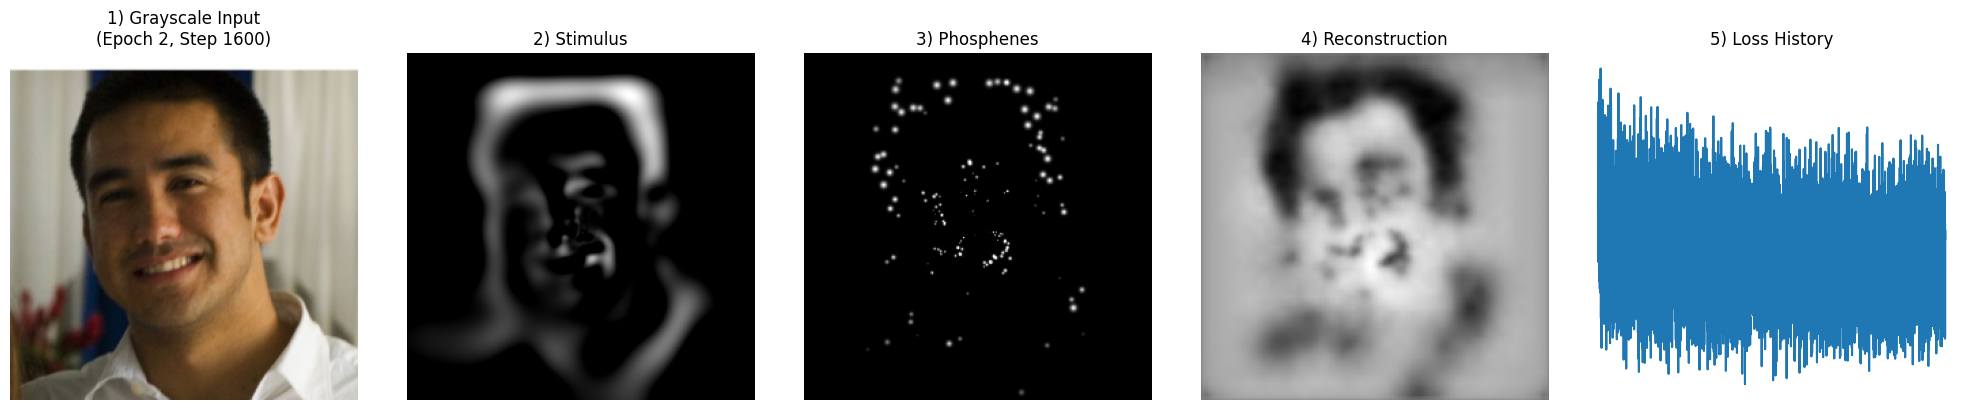

KeyboardInterrupt: 

In [55]:
LaPa_dataset = LaPaDataset(cfg)
batch_size = params['run']['batch_size']
dataloader = DataLoader(LaPa_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model, loss, optimizer
# decoder = E2E_Decoder(in_channels=1, out_channels=1, out_activation='relu').to(device)
decoder = ImprovedDecoder(in_channels=1, out_channels=1).to(device)

alpha = 0.5
beta  = 0.5

# criterion = nn.MSELoss()  # You can later add other metrics
criterion = HybridLoss(alpha=0.5, beta=0.5)

optimizer = torch.optim.Adam(decoder.parameters(), lr=5e-5)

epochs = 10
log_interval = 100

losses = []

for epoch in range(epochs):
    decoder.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(dataloader):
        images = batch['image'].to(device)  # Raw input images (B, C, H, W)

        # Produce the phosphene representations using the grayscale method.
        # You could change 'grayscale' to other processing methods as needed.
        stimulus, phosphene_inputs = generate_phosphenes(batch, method='LoG')

        # Define your target as the original grayscale image (or a processed version if desired)
        # For instance, target is the grayscale stimulus (averaged over channels):
        targets = images.mean(dim=1, keepdim=True)

        # Forward pass through the decoder
        outputs = decoder(phosphene_inputs)

        # Compute loss on the reconstruction vs. target
        loss = criterion(outputs, targets)
        losses += [loss.item()]
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            clear_output(wait=True)
            print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}')
            visualize_training_sample(
                batch=batch,
                stimulus=stimulus,
                phosphene_inputs=phosphene_inputs,
                reconstructions=outputs,
                losses=losses,
                epoch=epoch+1,
                step=batch_idx
            )
    
    avg_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')
    visualize_training_sample(
        batch=batch,
        stimulus=stimulus,
        phosphene_inputs=phosphene_inputs,
        reconstructions=outputs,
        losses=losses,
        epoch=epoch+1,
        step=batch_idx
    ) 